In [1]:
import time
import numpy as np
import random
import keras_tuner as kt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import GlobalMaxPooling2D, Activation, Dense, Conv1D, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, GlobalMaxPooling1D
from tensorflow.keras import optimizers
import itertools
from sklearn.utils import shuffle
from scipy import signal
%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras import regularizers


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

In [2]:
def showHistory(history):
    plt.rcParams['figure.figsize'] = [5, 5]
    for key in history.history.keys():

        if 'val_' not in key and 'lr' != key:
            try:
                plt.clf()
                plt.plot(history.history[key])
                plt.plot(history.history['val_'+key])
                plt.ylabel(key)
                plt.xlabel('epoch')
                plt.legend(['train', 'validation'], loc='upper left')
                plt.show()
            except:
                ...


classes = ['Rest','Left','Right']

def smoothLabels(label, factor = 0.05):
    label *= (1 - factor)
    label += (factor / len(label))
    return label

def oneHot(label, classes = classes):
    label = to_categorical(label,num_classes=len(classes))
    return smoothLabels(label)

def applyOneHot(data):
    new = []
    for y in data:
        new.append(oneHot(y))
    return np.array(new)

def DCFilter(data):
    new_data = []
    for d in data:
        new_data.append(d-np.mean(d))
    return np.array(new_data)

def notchFilter(data, f0 = 60.0, Q = 30.0, fs = 500):
    b, a = signal.iirnotch(f0, Q, fs)
    data = signal.filtfilt(b, a, data, axis=1)
    return np.array(data)

def preProcess(data):
    data = signal.resample(data,   signal_length,axis =-1)
  
    new_data = []
    for d in data:
        d = DCFilter(d)
        d = notchFilter(d)
        new_data.append(normalize(d, norm='l2'))
    return np.array(new_data)

def showMe(data):
    
    plt.rcParams["figure.figsize"] = [17, 2]
    fig, (c1, c2, c3, c4, c5, c6) = plt.subplots(1, 6)
    c1.plot(data[0])
    c2.plot(data[1])
    c3.plot(data[2])
    c4.plot(data[3])
    c5.plot(data[4])
    c6.plot(data[5])
    plt.show()

In [12]:
signal_length = 100

resource_path = 'resources/'
train_sessions = ['session_0', 'session_1', 'session_2']

class_0 = []
class_1 = []
class_2 = []
for session in train_sessions:
    class_0.append(np.load(os.path.join(resource_path,session,classes[0]+'.npy')))
    class_1.append(np.load(os.path.join(resource_path,session,classes[1]+'.npy')))
    class_2.append(np.load(os.path.join(resource_path,session,classes[2]+'.npy')))
class_0 = np.concatenate((class_0),axis=0)
class_1 = np.concatenate((class_1),axis=0)
class_2 = np.concatenate((class_2),axis=0)


class_0 = preProcess(class_0)
class_1 = preProcess(class_1)
class_2 = preProcess(class_2)
print(class_0.shape)


(90, 6, 100)


In [ ]:
class_0_avg = class_0.mean(axis=0)
showMe(class_0_avg)

In [ ]:
class_1_avg = class_1.mean(axis=0)
showMe(class_1_avg)

In [ ]:
class_2_avg = class_2.mean(axis=0)
showMe(class_2_avg)

In [ ]:
for i in range(5):
    showMe(class_1[i])

In [ ]:
for i in range(5):
    showMe(class_0[i])

In [13]:
X = np.concatenate((class_0,class_1,class_2),axis = 0)
y = np.concatenate(( np.zeros(class_0.shape[0]),np.ones(class_1.shape[0]),np.ones(class_1.shape[0])*2))


#SHUFFLE DATA
c = list(zip(X, y))
random.shuffle(c)
X,y = zip(*c)
X = np.array(X)
y = np.array(y)


X = np.expand_dims(X, axis = -1) 

y = applyOneHot(y)

print(X.shape)
print(y.shape)


(270, 6, 100, 1)
(270, 3)


In [14]:
#AUGMENT
noise = np.random.normal(0,0.1,X.size)
noise = np.reshape(noise,X.shape)

augmented = X + noise
X_aug = np.concatenate((X,augmented))
y_aug = np.concatenate((y,y))

print(X_aug.shape)
print(y_aug.shape)

(540, 6, 100, 1)
(540, 3)


In [24]:
def get_model():
    inspected_chanels= X.shape[1]
    signal_length=     X.shape[2]
    input_layer = keras.Input(shape = (inspected_chanels,signal_length,1), name='input')


    l2 = 0.001
    
    x     = layers.Conv2D(64, kernel_size=(6,6), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(input_layer)
    x     = layers.BatchNormalization()(x)
    x     = layers.AveragePooling2D(pool_size=(1,5))(x)

    # x     = layers.Conv2D(32, kernel_size=(1,5), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    # x     = layers.BatchNormalization()(x)
    # x     = layers.AveragePooling2D(pool_size=(1,2))(x)

    x     = layers.Conv2D(32, kernel_size=(6,6), padding='same', activation='relu', kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.BatchNormalization()(x)
  

    x     = layers.GlobalAveragePooling2D()(x)
    x     = layers.Dense(50, kernel_regularizer=regularizers.l2(l2))(x)
    x     = layers.Dropout(0.2)(x)


    output = layers.Dense(len(classes), activation='softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output)
    model.summary()
    return model

In [32]:

model = get_model()
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=30,
    decay_rate=0.9
    )

opt = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=opt,
          loss='categorical_crossentropy',
          metrics=['accuracy']
         )


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6, 100, 1)]       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 6, 100, 64)        2368      
_________________________________________________________________
batch_normalization_13 (Batc (None, 6, 100, 64)        256       
_________________________________________________________________
average_pooling2d_7 (Average (None, 6, 20, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 6, 20, 32)         73760     
_________________________________________________________________
batch_normalization_14 (Batc (None, 6, 20, 32)         128       
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0   

(486, 6, 100, 1) (486, 3)
Batch size: 54


C:\Users\Lapos\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3504: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


Epoch 1/100
9/9 [==============================] - 11s 1s/step - loss: 1.1938 - accuracy: 0.3087 - val_loss: 1.1827 - val_accuracy: 0.3333
Epoch 2/100
9/9 [==============================] - 8s 873ms/step - loss: 1.1752 - accuracy: 0.3728 - val_loss: 1.1825 - val_accuracy: 0.3333
Epoch 3/100
9/9 [==============================] - 4s 482ms/step - loss: 1.1531 - accuracy: 0.4138 - val_loss: 1.1822 - val_accuracy: 0.3333
Epoch 4/100
9/9 [==============================] - 4s 463ms/step - loss: 1.1302 - accuracy: 0.5279 - val_loss: 1.1820 - val_accuracy: 0.3333
Epoch 5/100
9/9 [==============================] - 4s 473ms/step - loss: 1.1272 - accuracy: 0.4543 - val_loss: 1.1818 - val_accuracy: 0.3333
Epoch 6/100
9/9 [==============================] - 4s 420ms/step - loss: 1.1054 - accuracy: 0.5299 - val_loss: 1.1818 - val_accuracy: 0.3333
Epoch 7/100
9/9 [==============================] - 4s 444ms/step - loss: 1.1215 - accuracy: 0.4938 - val_loss: 1.1822 - val_accuracy: 0.3333
Epoch 8/100
9/9

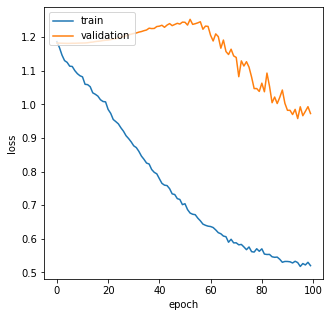

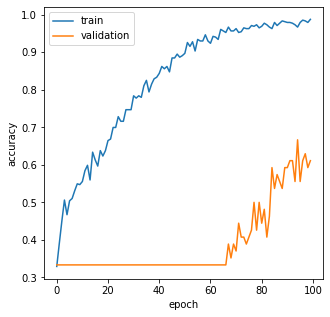

(486, 6, 100, 1) (486, 3)
Batch size: 54
Epoch 1/100
9/9 [==============================] - 4s 464ms/step - loss: 0.5573 - accuracy: 0.9362 - val_loss: 0.6103 - val_accuracy: 0.9444
Epoch 2/100
9/9 [==============================] - 4s 443ms/step - loss: 0.5552 - accuracy: 0.9444 - val_loss: 0.6369 - val_accuracy: 0.9074
Epoch 3/100
9/9 [==============================] - 4s 433ms/step - loss: 0.5504 - accuracy: 0.9403 - val_loss: 0.6625 - val_accuracy: 0.8704
Epoch 4/100
9/9 [==============================] - 4s 469ms/step - loss: 0.5486 - accuracy: 0.9568 - val_loss: 0.6765 - val_accuracy: 0.8333
Epoch 5/100
9/9 [==============================] - 4s 482ms/step - loss: 0.5375 - accuracy: 0.9506 - val_loss: 0.6406 - val_accuracy: 0.8889
Epoch 6/100
9/9 [==============================] - 4s 449ms/step - loss: 0.5337 - accuracy: 0.9691 - val_loss: 0.6488 - val_accuracy: 0.8704
Epoch 7/100
9/9 [==============================] - 4s 439ms/step - loss: 0.5468 - accuracy: 0.9506 - val_loss: 0.

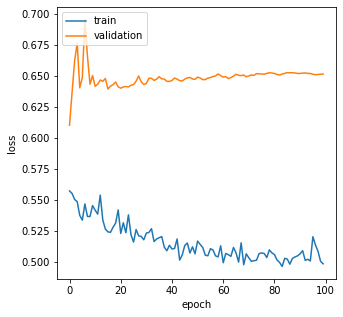

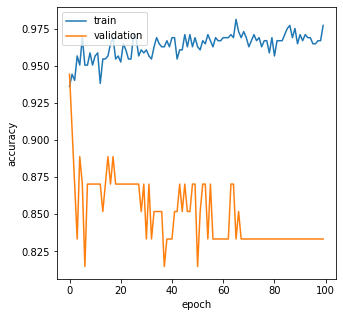

0.6666666865348816
0.9444444179534912


In [33]:
skf = StratifiedKFold(n_splits=10)
tf.config.run_functions_eagerly(True)
accs = []
models = []
for train, test in skf.split(X_aug, y_aug.argmax(axis=1)):
  
    X_train = X_aug[train]
    X_test  = X_aug[test]
    y_train = y_aug[train]
    y_test  = y_aug[test]
    print(X_train.shape, y_train.shape)


    batch_size = len(X_test) # len(X_train)
    print("Batch size: {}".format(batch_size))

    history = model.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        batch_size=batch_size,
                        epochs=100,
                        shuffle=True)

    showHistory(history)          
    acc = max(history.history['val_accuracy'])
    accs.append(acc)                       
    models.append(model)
    #break
    if acc > 0.9:
        break


model = models[accs.index(max(accs))]
for acc in accs:
    print(acc)

In [30]:
model.save('val_loss_'+str(max(accs)))

INFO:tensorflow:Assets written to: val_loss_1.0\assets


In [31]:
pred = model(X)
conf_matrix = np.zeros((3,3))
for i in range(int(len(pred))):
    prediction = np.argmax(pred[i])
    gt         = np.argmax(y[i])
    conf_matrix[gt][prediction] += 1
conf_matrix

array([[89.,  0.,  1.],
       [ 2., 86.,  2.],
       [ 1.,  1., 88.]])